### Task

Необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('/Users/mariashemyakina/Downloads/materialy-k-zanyatiy-2019-25-06/adult.csv')

In [3]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Видны непонятные значения в виде "?" знака. Попробуем заменить их на None, выявив таким образом пропуски в данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
data.replace(['?'], [None], inplace = True)

In [6]:
data.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Разделим наши данный на категориальные и числовые

In [7]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print (categorical_columns)
print (numerical_columns)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [8]:
data[categorical_columns].describe()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


Заменим пропуски в категориальных переменных на топовые (частовстречающиеся) значения 

In [9]:
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])



In [10]:
data.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Посмотрим числовые переменные

In [11]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Посмотрим какие значения у ключевого атрибута income

In [12]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

Для удобства заменим '>50K' на 1, а '<=50K' на 0

In [13]:
data.replace('<=50K', 0, inplace = True)
             

In [14]:
data.replace('>50K', 1, inplace = True)

In [15]:
data['income'].unique()

array([0, 1])

Разделим данные на Х и у. Т.к. доход у нас ключевой атрибут, то разделение будет выглядеть так:

In [16]:
X = data.loc[:, data.columns != 'income']
y = data[data.columns[-1]]

In [17]:
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States


In [18]:
y[:7]

0    0
1    0
2    1
3    1
4    0
5    0
6    0
Name: income, dtype: int64

Посмотрим на корреляцию данных

In [19]:
X.corr().style.background_gradient()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1,-0.0766281,0.0309404,0.077229,0.0569438,0.0715583
fnlwgt,-0.0766281,1,-0.0387607,-0.00370639,-0.00436615,-0.0135187
educational-num,0.0309404,-0.0387607,1,0.125146,0.0809719,0.143689
capital-gain,0.077229,-0.00370639,0.125146,1,-0.0314408,0.0821573
capital-loss,0.0569438,-0.00436615,0.0809719,-0.0314408,1,0.0544672
hours-per-week,0.0715583,-0.0135187,0.143689,0.0821573,0.0544672,1


Разделим выборку на тренировочную и тестовую.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [21]:
X.shape

(48842, 14)

In [22]:
X_train.shape

(39073, 14)

In [23]:
X_test.shape

(9769, 14)

In [24]:
num_columns = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

In [25]:
def get_cat_categories(data, cat_columns):
    categories = []
    for column in cat_columns:
        categories.append(list(data[column].unique()))    
    return categories

In [26]:
categories = get_cat_categories(data, cat_columns)

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=categories), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    sparse_threshold=0,
    remainder='drop'
)

Соберем пайплайн

In [28]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

А теперь все это запихнем в гридсерч

In [29]:
grid_params = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2']
}

In [30]:
grid = GridSearchCV(clf, param_grid=grid_params, n_jobs=-1, cv=10)

In [31]:
grid.fit(X, y)

/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0,
         transformer_weights=None,
         transformers=[('cat', OneHotEncoder(categorical_features=None,
       categories=[['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-em...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'classifier__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
grid.best_score_

0.8511322222677205

In [33]:
grid.best_params_

{'classifier__C': 0.1, 'classifier__penalty': 'l2'}

In [34]:
model = grid.best_estimator_

Посмотрим на остатки

In [35]:
model.named_steps['classifier'].intercept_

array([-1.1569854])

Заберем название фичей из препроцессора

In [36]:
def get_feature_names(column_transformer, df):
    feature_names = []
    for _, tr, columns in column_transformer.transformers:
        if type(tr).__name__ == 'OneHotEncoder':
            tr.fit(df[columns]) # wtf?? удивительно, но факт, но ColumnTransformer сначала клонирует незафиченный непосредственно трансформер, а потом его выполняет
            feature_names.extend(list(tr.get_feature_names(columns)))
        elif type(tr).__name__ == 'StandardScaler':
            feature_names.extend(columns)
        else:
            raise RuntimeError(f'Unknown class: {type(tr).__name__}, plrase update function')
    return feature_names

In [37]:
feature_names = get_feature_names(model.named_steps['preprocessor'], X)

In [38]:
len(feature_names)

105

In [39]:
df_coef = pd.DataFrame()
df_coef['Features'] = pd.Series(feature_names)
df_coef['Coef'] = model.named_steps['classifier'].coef_[0]

Посмотрим на максимально влияющие признаки

In [40]:
df_coef.sort_values(by=['Coef']).head(10)

,Features,Coef
45,relationship_Own-child,-1.030543
24,marital-status_Never-married,-0.982924
32,occupation_Farming-fishing,-0.918411
57,gender_Female,-0.903250
35,occupation_Other-service,-0.833941
50,relationship_Other-relative,-0.717640
2,workclass_Self-emp-not-inc,-0.636779
43,occupation_Handlers-cleaners,-0.614900
72,native-country_Columbia,-0.571244
61,native-country_Mexico,-0.552080


In [41]:
df_coef.sort_values(by=['Coef'], ascending=False).head(10)

,Features,Coef
102,capital-gain,2.268606
25,marital-status_Married-civ-spouse,1.226205
49,relationship_Wife,0.972340
101,educational-num,0.729994
38,occupation_Exec-managerial,0.698098
39,occupation_Tech-support,0.490839
30,marital-status_Married-AF-spouse,0.445197
81,native-country_Italy,0.385915
3,workclass_Federal-gov,0.377936
104,hours-per-week,0.376809


Пробуем на валидационной выборке

In [43]:
y_pred = model.predict(X_test)

/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [44]:
model.score(X_test, y_test)

/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.8554611526256526

Нарисуем ROC AUC

In [45]:
def plt_roc_auc(title, fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC {roc_auc_train}')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC {roc_auc_test}')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()    

In [46]:
y_pred_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob = model.predict_proba(X_test)[:, 1]

/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/mariashemyakina/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [47]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob)
roc_auc_train = roc_auc_score(y_train, y_prob_train)
roc_auc_test = roc_auc_score(y_test, y_prob)

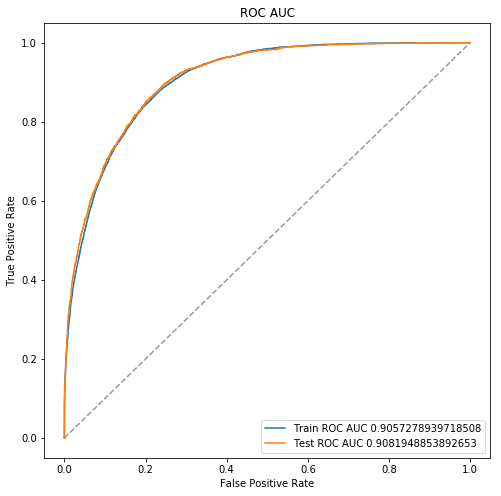

In [48]:
plt_roc_auc('ROC AUC', fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test)